In [1]:
import ROOT
import numpy as np
import uproot
from math import sqrt
from numpy import unwrap
from numpy import arange
from rootpy.vector import LorentzVector
import matplotlib.pyplot as plt
%matplotlib inline

Welcome to JupyROOT 6.14/00


DEBUG:matplotlib] $HOME=/home/afwebb
DEBUG:matplotlib] matplotlib data path /usr/lib64/python3.6/site-packages/matplotlib/mpl-data
DEBUG:matplotlib] loaded rc file /usr/lib64/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc
DEBUG:matplotlib] matplotlib version 2.2.2
DEBUG:matplotlib] interactive is False
DEBUG:matplotlib] platform is linux
DEBUG:matplotlib] loaded modules: ['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconfig', '_sysconfigdata_m_linux_x86_64-linux-gnu', 'types', 'functools', '_functools', 'collections', 'operator', '_operator', 'keyword', 'heapq', '_heapq', 'itertools'

DEBUG:matplotlib] CACHEDIR=/home/afwebb/.cache/matplotlib
DEBUG:matplotlib.font_manager] Using fontManager instance from /home/afwebb/.cache/matplotlib/fontList.json
DEBUG:matplotlib.backends] backend module://ipykernel.pylab.backend_inline version unknown
DEBUG:matplotlib.backends] backend module://ipykernel.pylab.backend_inline version unknown
DEBUG:matplotlib.backends] backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
f=uproot.open('/data_ceph/afwebb/datasets/v8_ttH/GN1_ExtTruth/mc16d/345874.root')
nom=f.get('nominal')

In [3]:
events = []

def calc_phi(phi_0, new_phi):
    new_phi = new_phi-phi_0
    if new_phi>math.pi:
        new_phi = new_phi - 2*math.pi
    if new_phi<-math.pi:
        new_phi = new_phi + 2*math.pi
    return new_phi


In [4]:
la=f['nominal'].lazyarrays(['m_truth*','dilep_type','higgs*','lep_Pt*','lep_Eta_*', 'lep_E_*','total_charge',
                            'total_leptons',
                           'lep_Phi*','lep_ID*','lep_Index*',
                            #'electron_eta','electron_phi','electron_pt',
                            #'muon_eta','muon_phi','muon_pt',
                           'm_jet*','selected_jets', 'm_truth_jet_pt', 'm_truth_jet_eta', 
                            'm_truth_jet_phi', 'm_truth_jet_m', 'm_truth_jet_Hcount', 'm_truth_jet_Tcount','nJets_OR_T',
                            'MET_RefFinal_et', 'MET_RefFinal_phi'])

In [5]:
from collections import namedtuple
parttype = namedtuple('parttype', ['barcode', 'pdgid', 'status', 'eta', 'phi', 'pt', 'parents', 'children'])

def make_partdict(la, idx):
    rv = dict(zip(la[b'm_truth_barcode'][idx],
                 (parttype(*_2) for
                  _2 in zip(la[b'm_truth_barcode'][idx],
                            la[b'm_truth_pdgId'][idx],
                            la[b'm_truth_status'][idx],
                            la[b'm_truth_eta'][idx],
                            la[b'm_truth_phi'][idx],
                            la[b'm_truth_pt'][idx],
                            la[b'm_truth_parents'][idx],
                            la[b'm_truth_children'][idx])
                 )
                 ))
    return rv

In [6]:
from collections import namedtuple
jettype = namedtuple('jettype', ['pdgid','eta', 'phi', 'pt', 'E'])

def make_jetdict(la, idx):
    rv = dict(zip([x for x in range(len(la[b'm_jet_pt'][idx]))],
                 (jettype(*_2) for
                  _2 in zip(la[b'm_jet_flavor_truth_label_ghost'][idx],
                            la[b'm_jet_eta'][idx],
                            la[b'm_jet_phi'][idx],
                            la[b'm_jet_pt'][idx],
                            la[b'm_jet_E'][idx])
                 )
                 ))
    return rv

In [7]:
def drCheck(eta, phi, truth_eta, truth_phi, cut):
    dr = sqrt( (phi-truth_phi)**2 + (eta-truth_eta)**2 )
    #print('DR', dr, pt/part.pt-1)                                                                                                               
    #print('DR', dr)                                                                                                                             
    return dr < cut

In [8]:
current = 0
nMatch = 0
higgVecs = []

In [82]:
len(la[b'nJets_OR_T'])

2282484

In [9]:
fourVecDicts = []

for idx in range(200000):
    #current+=1
    if idx%10000==0:
        print(idx)                                                                                                                                  

    if la[b'higgsDecayMode'][idx] != 3: continue
    if la[b'total_leptons'][idx] < 1: continue
    if la[b'dilep_type'][idx] < 1: continue
    if la[b'total_charge'][idx] == 0: continue
    if la[b'nJets_OR_T'][idx] <4: continue
        
    higgCand = LorentzVector()
    
    fourVecs = {}
    
    met = LorentzVector()
    met.SetPtEtaPhiE(la[b'MET_RefFinal_et'][idx], 0, la[b'MET_RefFinal_phi'][idx], la[b'MET_RefFinal_et'][idx])
    
    fourVecs['met'] = met
    
    higgCand+=met
        
    truth_dict = make_partdict(la, idx)
    jet_dict = make_jetdict(la,idx)

    lepPts = [la[b'lep_Pt_0'][idx], la[b'lep_Pt_1'][idx]]
    lepEtas = [la[b'lep_Eta_0'][idx], la[b'lep_Eta_1'][idx]]
    lepPhis = [la[b'lep_Phi_0'][idx], la[b'lep_Phi_1'][idx]]
    lepEs = [la[b'lep_E_0'][idx], la[b'lep_E_1'][idx]]
    lepIDs = [la[b'lep_ID_0'][idx], la[b'lep_ID_1'][idx]]
    
    lepMatch = -1
    for i in range(2):
        
        lepH = LorentzVector()
        lepH.SetPtEtaPhiE(lepPts[i], lepEtas[i], lepPhis[i], lepEs[i])
        
        for a in truth_dict:
            if abs(truth_dict[a].pdgid) == abs(lepIDs[i]):
                if drCheck(lepEtas[i], lepPhis[i], truth_dict[a].eta, truth_dict[a].phi, 0.01):
                    p = truth_dict[a].parents[0]
                    terminal = False
                    while not terminal:
                        if p in truth_dict:
                            a = p
                            try:
                                p = truth_dict[a].parents[0]
                            except:
                                terminal = True
                        else: terminal = True
                    if truth_dict[a].pdgid == 25: 
                        higgCand+=lepH
                        lepMatch = i
                        fourVecs['higgsLep'] = lepH
            if lepMatch!=i: 
                fourVecs['badLep'] = lepH
                
    if lepMatch == -1:
        continue
                        
    
    c = make_partdict(la,idx)
    higgsID = 0
    for x in c:
        if c[x].pdgid==25: higgsID = x

    jetCands = []
    jetTest = []
    Ws = c[higgsID].children
    for w in Ws:
        for child in c[w].children:
            if child in c: ch = c[child]
            else: continue
            if abs(ch.pdgid) in range(1,5): jetTest.append(child)
            #elif abs(ch.pdgid)==24: 
        jetCands=[*jetCands, *c[w].children]
        
    if len(jetTest)!=2:
        continue
        
    match=0  
    truthJets = []
    higgsJets=[]
    badJets=[]
    for j in jetCands:
        if j not in c:
            print('not found')
            continue
        if abs(c[j].pdgid) not in range(1, 5):
            continue
        else:
            #match = False
            for i in range(len(la[b'm_jet_pt'][idx])):#la[b'selected_jets'][i]:

                jet_pt = la[b'm_jet_pt'][idx][i]
                jet_eta = la[b'm_jet_eta'][idx][i]
                jet_phi = la[b'm_jet_phi'][idx][i]
                jet_E = la[b'm_jet_E'][idx][i]
                jet_flav = la[b'm_jet_flavor_truth_label_ghost'][idx][i]

                jetVec = LorentzVector()
                jetVec.SetPtEtaPhiE(jet_pt, jet_eta, jet_phi, jet_E)
                
                dr = sqrt(unwrap([jet_phi-c[j].phi])**2+(jet_eta-c[j].eta)**2)
                if dr<0.3 and jet_flav==abs(c[j].pdgid):
                    truthJets.append(i)
                    higgCand+=jetVec
                    higgsJets.append(jetVec)
                    match+=1
                else:
                    badJets.append(jetVec)
               
    if match!=2: continue

    fourVecs['higgsJets'] = higgsJets
    fourVecs['badJets'] = badJets
    fourVecs['higgsCand'] = higgCand
    
    fourVecDicts.append(fourVecs)
    
    higgVecs.append(higgCand)


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000


KeyboardInterrupt: 

(array([  0.,  25.,  60.,  51.,  49.,  54.,  69.,  99., 109., 145., 174.,
         46.,  34.,  16.,   9.,   5.,   4.,   1.,   1.,   2.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3, 3.6,
        3.9, 4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. ]),
 <a list of 20 Patch objects>)

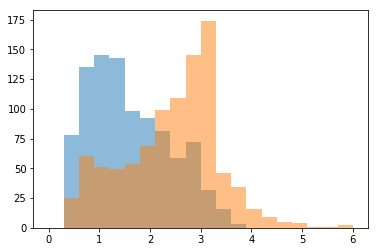

In [34]:
plt.hist([x['higgsJets'][0].DeltaR(x['higgsJets'][1]) for x in fourVecDicts], 20, log=False, range=(0,6), alpha=0.5, label='truth')
plt.hist([x['badJets'][0].DeltaR(x['badJets'][1]) for x in fourVecDicts], 20, log=False, range=(0,6), alpha=0.5, label='fake')

(array([ 42.,  38.,  61.,  73.,  83.,  82.,  81.,  91., 114., 126.,  92.,
         37.,  13.,   9.,   3.,   3.,   3.,   2.,   1.,   0.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3, 3.6,
        3.9, 4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. ]),
 <a list of 20 Patch objects>)

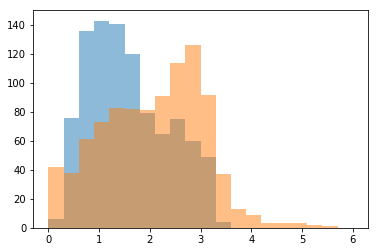

In [38]:
plt.hist([x['higgsLep'].DeltaR(x['higgsJets'][1]) for x in fourVecDicts], 20, log=False, range=(0,6), alpha=0.5, label='truth')
plt.hist([x['higgsLep'].DeltaR(x['badJets'][1]) for x in fourVecDicts], 20, log=False, range=(0,6), alpha=0.5, label='fake')

(array([ 0., 11., 55., 83., 92., 88., 78., 76., 67., 46., 52., 28., 38.,
        38., 20., 27., 17., 12., 15., 10.]),
 array([     0.,  30000.,  60000.,  90000., 120000., 150000., 180000.,
        210000., 240000., 270000., 300000., 330000., 360000., 390000.,
        420000., 450000., 480000., 510000., 540000., 570000., 600000.]),
 <a list of 20 Patch objects>)

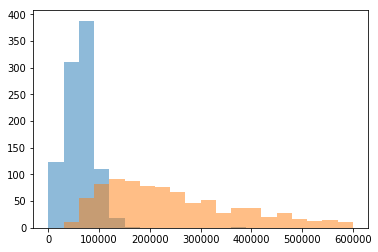

In [52]:
plt.hist([(x['higgsJets'][0]+x['higgsJets'][1]).M() for x in fourVecDicts], 20, log=False, range=(0,600000), alpha=0.5, label='truth')
plt.hist([(x['badJets'][0]+x['badJets'][1]).M() for x in fourVecDicts], 20, log=False, range=(0,600000), alpha=0.5, label='fake')

In [41]:
[(x['higgsJets'][0]+x['higgsJets'][1]).Pt() for x in fourVecDicts]

[361192.63574798836,
 77810.16953259501,
 205521.41073897207,
 132159.68444661502,
 96247.52323097219,
 44899.92493926837,
 33009.08348601462,
 77024.40321510837,
 54378.36092716929,
 163749.28045203543,
 37381.945352866656,
 104781.81835300349,
 206146.49925227053,
 188303.7745041937,
 52189.203224275494,
 96370.03522232805,
 39053.69931822444,
 62835.53747689312,
 151908.89704026625,
 77628.33495727638,
 65837.68632776129,
 115034.16172126197,
 25547.66715548181,
 19145.436431633778,
 70590.93168419297,
 56618.677765463966,
 57901.0212622747,
 129405.06670968999,
 130274.52546661352,
 235450.1786133105,
 55013.219792206044,
 50531.1390073173,
 68154.56311577644,
 35183.863712438026,
 34732.13057207077,
 24566.07572561702,
 38856.19950477379,
 134832.2795495353,
 216553.0801525917,
 49813.066288193986,
 392882.8764051077,
 44286.23882576187,
 91618.2021374599,
 92057.06284313837,
 56227.117258916194,
 110198.46243340251,
 91671.87572716574,
 247581.46214817915,
 69956.53060302141,
 79

In [47]:
import random

In [46]:
jjHiggs = [x['higgsJets'][0]+x['higgsJets'][1] for x in fourVecDicts]
lj0Higgs = [x['higgsLep']+x['higgsJets'][0] for x in fourVecDicts]
lj1Higgs = [x['higgsLep']+x['higgsJets'][1] for x in fourVecDicts]

In [72]:
events = []

In [73]:
for f in fourVecDicts:
    k = {}
    
    k['match'] = 1
    
    k['dRjj'] = f['higgsJets'][0].DeltaR(f['higgsJets'][1])
    k['Ptjj'] = (f['higgsJets'][0]+f['higgsJets'][1]).Pt()
    k['Mjj'] = (f['higgsJets'][0]+f['higgsJets'][1]).M()
    
    k['dRlj0'] = f['higgsLep'].DeltaR(f['higgsJets'][0])
    k['Ptlj0'] = (f['higgsLep']+f['higgsJets'][0]).Pt()
    k['Mlj0'] = (f['higgsLep']+f['higgsJets'][0]).M()

    k['dRlj1'] = f['higgsLep'].DeltaR(f['higgsJets'][1])
    k['Ptlj1'] = (f['higgsLep']+f['higgsJets'][1]).Pt()
    k['Mlj1'] = (f['higgsLep']+f['higgsJets'][1]).M()
    
    k['MlepMet'] = (f['higgsLep']+f['met']).M()
    k['dRlepMep'] = f['higgsLep'].DeltaR(f['met'])

    k['MhiggsCand'] = (f['higgsJets'][0]+f['higgsJets'][1]+f['higgsLep']+f['met']).M()
    
    events.append(k)
    

In [74]:
for f in fourVecDicts:

    for q in range(3):
        
        k = {}
    
        k['match'] = 0
        
        i,j = random.sample(range(len(f['badJets'])),2)
    
        k['dRjj'] = f['badJets'][i].DeltaR(f['badJets'][j])
        k['Ptjj'] = (f['badJets'][i]+f['badJets'][j]).Pt()
        k['Mjj'] = (f['badJets'][i]+f['badJets'][j]).M()

        k['dRlj0'] = f['badLep'].DeltaR(f['badJets'][i])
        k['Ptlj0'] = (f['badLep']+f['badJets'][i]).Pt()
        k['Mlj0'] = (f['badLep']+f['badJets'][i]).M()

        k['dRlj1'] = f['badLep'].DeltaR(f['badJets'][j])
        k['Ptlj1'] = (f['badLep']+f['badJets'][j]).Pt()
        k['Mlj1'] = (f['badLep']+f['badJets'][j]).M()

        k['MlepMet'] = (f['badLep']+f['met']).M()
        k['dRlepMep'] = f['badLep'].DeltaR(f['met'])

        k['MhiggsCand'] = (f['badJets'][i]+f['badJets'][j]+f['badLep']+f['met']).M()

        events.append(k)

In [67]:
events

[{'match': 1,
  'dRjj': 0.8033820909144362,
  'Ptjj': 361192.63574798836,
  'Mjj': 112347.60909176776,
  'dRlj0': 0.25063310174792625,
  'Ptlj0': 386412.55841170653,
  'Mlj0': 66973.49579759035,
  'dRlj1': 1.0525028272353223,
  'Ptlj1': 104266.45254739898,
  'Mlj1': 57297.460375159346,
  'MlepMet': 119691.47135984886,
  'dRlepMep': 2.763025758906625,
  'MhiggsCand': 359574.51466340816},
 {'match': 1,
  'dRjj': 1.5690449061665304,
  'Ptjj': 77810.16953259501,
  'Mjj': 67528.6807509858,
  'dRlj0': 0.3088935871072318,
  'Ptlj0': 106538.72641670765,
  'Mlj0': 18893.13222228448,
  'dRlj1': 1.837717793604121,
  'Ptlj1': 65268.70516273911,
  'Mlj1': 71903.7061628859,
  'MlepMet': 130788.54518958142,
  'dRlepMep': 3.148553855407514,
  'MhiggsCand': 225970.13131637164},
 {'match': 1,
  'dRjj': 1.1400876691230974,
  'Ptjj': 205521.41073897207,
  'Mjj': 96632.92288451151,
  'dRlj0': 0.10034297226930929,
  'Ptlj0': 266486.41772437363,
  'Mlj0': 39145.325995726766,
  'dRlj1': 1.0427282539533331,
  

In [75]:
len(events)

3816

In [69]:
import pandas as pd

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [76]:
df = pd.DataFrame.from_dict(events)

In [80]:
from sklearn.utils import shuffle
df = shuffle(df)

In [81]:
df

,MhiggsCand,Mjj,MlepMet,Mlj0,Mlj1,Ptjj,Ptlj0,Ptlj1,dRjj,dRlepMep,dRlj0,dRlj1,match
306,326478.131148,24060.988000,275847.358740,39484.288139,63277.626481,69250.891999,54754.702803,58910.567812,0.553188,2.476296,1.312531,1.865675,1
1913,400399.931084,220943.611555,10951.382928,285410.090815,19108.733210,88645.325633,105557.675677,10445.206583,4.995015,0.770899,4.110116,2.745492,0
1937,53066.001319,31914.448033,8361.973826,27558.587441,3144.923450,34825.289367,26325.314417,63071.844339,2.089820,0.326055,2.085283,0.010779,0
2067,597952.803856,217129.580867,334015.229598,251462.911643,155234.968914,91407.044682,71791.832047,157290.311423,2.890161,2.575202,3.416983,1.553320,0
3131,165762.455936,61159.286535,60286.694394,14913.763430,125797.177714,176984.824479,43153.114615,181970.364108,1.457427,1.819286,0.752720,1.741061,0
1989,309888.863779,118882.851997,43441.037874,110910.701690,116424.147375,154356.068153,30770.346020,65779.730130,1.420859,0.761244,2.941278,2.533492,0
114,226729.339678,76568.039102,123889.179784,58670.978688,58980.505676,43123.341742,85691.109484,101919.909714,2.258367,1.480991,1.299329,1.057197,1
3287,979780.441831,416951.419166,115331.128280,426352.745150,96216.320842,86245.445871,145929.192507,172402.564577,3.252332,1.519566,3.872329,1.155575,0
110,279162.891297,121023.999248,111098.794538,49923.847732,78420.819391,246049.646562,282897.364295,142014.377750,0.959610,1.857857,0.153724,0.997678,1
275,133400.258289,47974.595487,66226.611429,44808.434137,41770.380632,49832.232461,24144.663886,26025.853662,1.503460,2.196331,2.652370,2.328140,1
